In [21]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 29.3 MB/s eta 0:00:00 0:00:01


In [7]:
!pip install openmeteo_requests
!pip install pandas
!pip install numpy
!pip install matplotlib.pyplot
!pip install geopandas
!pip install requests_cache
!pip install random
!pip install retry_requests
!pip install shapely.geometry
!pip install cartiflette


ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)
ERROR: No matching distribution found for matplotlib.pyplot
ERROR: Could not find a version that satisfies the requirement random (from versions: none)
ERROR: No matching distribution found for random
ERROR: Could not find a version that satisfies the requirement shapely.geometry (from versions: none)
ERROR: No matching distribution found for shapely.geometry


In [8]:
import random
import openmeteo_requests
import requests_cache
from retry_requests import retry
import geopandas as gpd
from cartiflette import carti_download
import matplotlib.pyplot as plt
from shapely.geometry import Point
import pandas as pd
import numpy as np


In [9]:
def generate_random_points_in_france1(num_points=50):
    points = []

    # Approximate boundaries for France (metropolitan)
    min_lat, max_lat = 41.0, 51.0  # Latitude range
    min_lon, max_lon = -5.0, 9.0   # Longitude range

    for _ in range(num_points):
        lat = random.uniform(min_lat, max_lat)
        lon = random.uniform(min_lon, max_lon)

        points.append((lat, lon))

    return points

# Generate 100 random points
random_points = generate_random_points_in_france1(50)

# Print the generated points
for idx, (lat, lon) in enumerate(random_points, start=1):
    print(f"Point {idx}: Latitude = {lat:.6f}, Longitude = {lon:.6f}")


Point 1: Latitude = 45.648343, Longitude = 2.354129
Point 2: Latitude = 50.539601, Longitude = 0.372855
Point 3: Latitude = 48.486630, Longitude = 1.865098
Point 4: Latitude = 43.856771, Longitude = 4.553802
Point 5: Latitude = 49.037259, Longitude = -2.551777
Point 6: Latitude = 42.499912, Longitude = -3.519507
Point 7: Latitude = 44.050597, Longitude = 8.884731
Point 8: Latitude = 44.711254, Longitude = 5.044945
Point 9: Latitude = 41.080841, Longitude = -0.834538
Point 10: Latitude = 43.564664, Longitude = 8.240620
Point 11: Latitude = 45.038481, Longitude = 4.822185
Point 12: Latitude = 48.846140, Longitude = -2.380549
Point 13: Latitude = 43.240524, Longitude = -1.866177
Point 14: Latitude = 42.917591, Longitude = -3.160479
Point 15: Latitude = 49.193791, Longitude = 5.126144
Point 16: Latitude = 45.838721, Longitude = -3.122301
Point 17: Latitude = 49.031616, Longitude = 2.983357
Point 18: Latitude = 42.070008, Longitude = 7.191316
Point 19: Latitude = 45.821215, Longitude = 4.01

In [13]:
def temperature_random_points(nb_points : int) -> pd.DataFrame  :
    # Liste des points aléatoires (exemple avec 2 points, étendre à 100 points)
    random_points = generate_random_points_in_france1(nb_points)

    # Date unique pour la requête (remplacez par la date souhaitée)
    date = "2024-12-02"

    # Setup the Open-Meteo API client with cache and retry on error
    cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    openmeteo = openmeteo_requests.Client(session=retry_session)

    # Créer un DataFrame consolidé pour stocker les résultats
    dataframes = []

    # Effectuer une requête pour chaque point
    for idx, (latitude, longitude) in enumerate(random_points, start=1):
        print(f"Traitement du point {idx}: Latitude = {latitude}, Longitude = {longitude}")

        # Paramètres de la requête pour chaque point
        params = {
            "latitude": latitude,
            "longitude": longitude,
            "hourly": "temperature_2m",
            "start_date": date,
            "end_date": date,
            "models": "meteofrance_seamless"
        }

        try:
            # Effectuer la requête Open-Meteo
            responses = openmeteo.weather_api("https://api.open-meteo.com/v1/forecast", params=params)
            response = responses[0]

            # Extraire les données horaires pour la température à 2m
            hourly = response.Hourly()
            hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()

            hourly_data = {
                "date": pd.date_range(
                    start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
                    end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
                    freq=pd.Timedelta(seconds=hourly.Interval()),
                    inclusive="left"
                ),
                "temperature_2m": hourly_temperature_2m
            }

            # Ajouter la latitude et la longitude aux données
            hourly_data["latitude"] = latitude
            hourly_data["longitude"] = longitude

            # Convertir en DataFrame et ajouter à la liste
            df = pd.DataFrame(data=hourly_data)
            dataframes.append(df)

        except Exception as e:
            print(f"Erreur lors du traitement du point {idx}: {e}")

    # Consolider tous les DataFrames
    final_dataframe = pd.concat(dataframes, ignore_index=True)

    # Sauvegarder les résultats dans un fichier CSV
    final_dataframe.to_csv("weather_data.csv", index=False)

    result = final_dataframe.loc[final_dataframe["date"] == "2024-12-02 00:00:00+00:00"].rename(columns = {'temperature_2m' : 'temperature'})
    
    
    return result



In [14]:
result = temperature_random_points(200)

Traitement du point 1: Latitude = 44.876231801092686, Longitude = 8.907030512482553
Traitement du point 2: Latitude = 50.54652468550672, Longitude = 3.6052283112787276
Traitement du point 3: Latitude = 49.558761653245654, Longitude = 2.415384571484097
Traitement du point 4: Latitude = 48.092131226036194, Longitude = 5.776482695706136
Traitement du point 5: Latitude = 49.45458345593581, Longitude = -4.292313638562921
Traitement du point 6: Latitude = 49.5671518973686, Longitude = 8.86208051045767
Traitement du point 7: Latitude = 41.87616761404253, Longitude = -2.5453357275585695
Traitement du point 8: Latitude = 42.41452309769067, Longitude = -1.8923019919134325
Traitement du point 9: Latitude = 43.56548252899089, Longitude = 5.651085567280019
Traitement du point 10: Latitude = 43.34263741774087, Longitude = -1.9899846253807008
Traitement du point 11: Latitude = 46.444303560733275, Longitude = 7.215080855187582
Traitement du point 12: Latitude = 41.579071536886104, Longitude = -0.21244

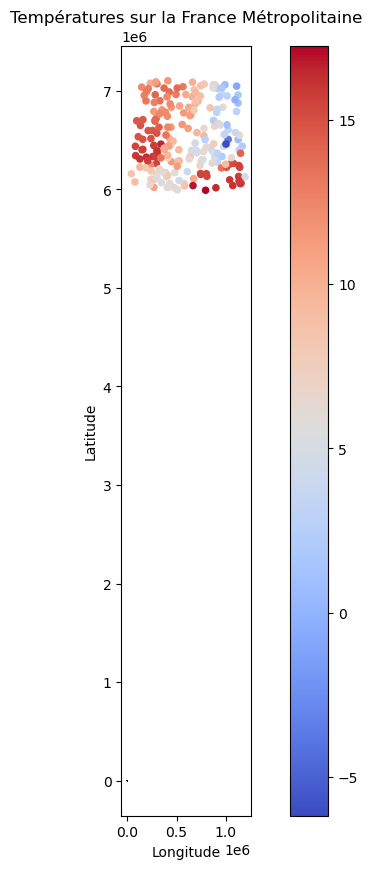

In [ ]:
result

from cartiflette import carti_download

france = carti_download(
    values=["France"],
    crs=4326,
    borders="REGION",
    vectorfile_format="geojson",
    simplification=50,
    filter_by="FRANCE_ENTIERE",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)
france = france.loc[france["INSEE_REG"] > 10]

# Convertir le DataFrame pandas en GeoDataFrame avec la projection EPSG:4326
geometry = [Point(xy) for xy in zip(result["longitude"], result["latitude"])]
geo_result = gpd.GeoDataFrame(result, geometry=geometry, crs="EPSG:4326")

# Reprojections de vos points en Lambert-93 (pour correspondre à france_2154)
geo_result_2154 = geo_result.to_crs(2154)

# Afficher la carte avec la France et les températures sur celle-ci
fig, ax = plt.subplots(figsize=(10, 10))

# Afficher les frontières de la France métropolitaine
france.boundary.plot(ax=ax, edgecolor="k", linewidth=0.5)

# Afficher les points de température sur la carte
# Utiliser une couleur pour représenter la température
geo_result_2154.plot(ax=ax, column="temperature", cmap="coolwarm", markersize=20, legend=True)

# Afficher la carte avec les légendes
plt.title("Températures sur la France Métropolitaine")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()




/opt/conda/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


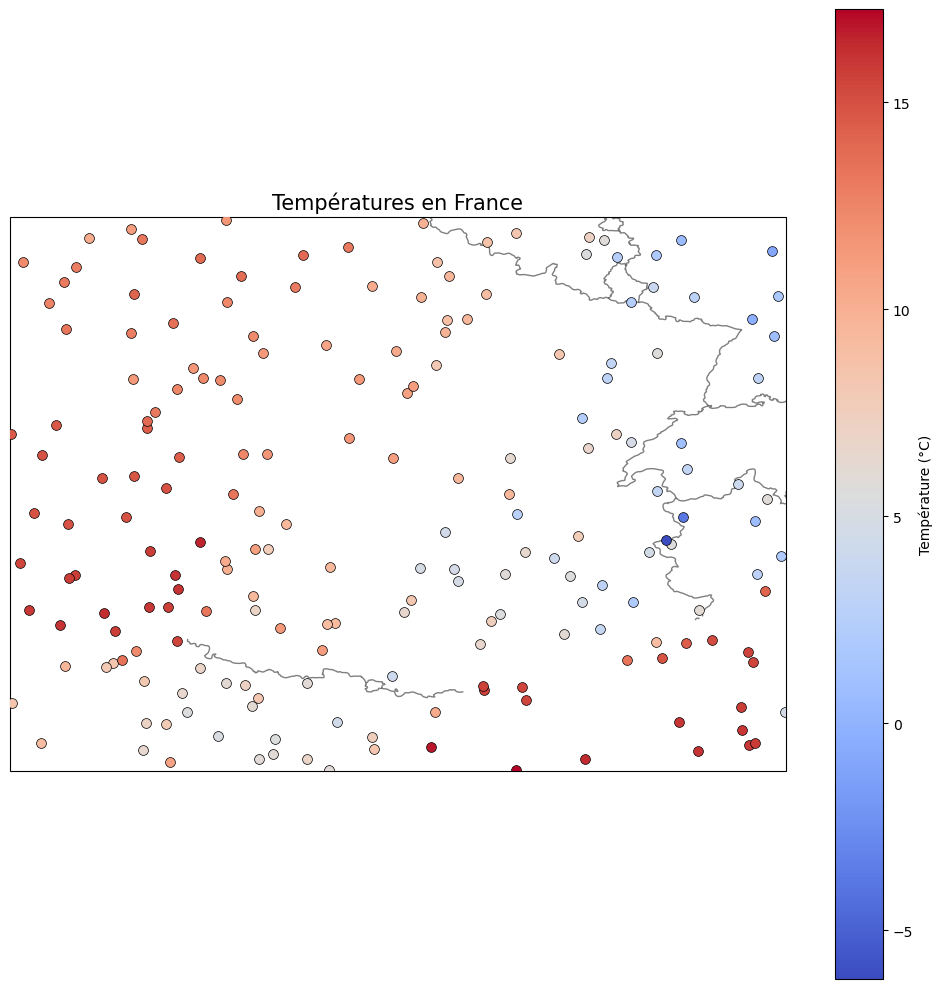